### TODO

Can we quantify how many additional PPIs we get from studying multiple isoforms relative a single isoform?

We would want to use the screening data, filtered by the pairwise test data, I guess.

Would need to distinguish beetween screening with the same clone twice vs two different isoforms?

Plot degree of binding partners vs. fraction of isoforms interacting

In [1]:
import os
from collections import Counter

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from ccsblib import huri

from data_loading import (load_isoform_and_paralog_y2h_data,
                          load_valid_isoform_clones,
                          load_paralog_pairs,
                          load_ppi_partner_categories,
                          load_tf_families)
from plotting import y2h_ppi_per_paralog_pair_plot

%matplotlib inline
pd.set_option('display.max_columns', 50)

In [2]:
y2h = load_isoform_and_paralog_y2h_data()
isoforms = load_valid_isoform_clones()
pairs = load_paralog_pairs()

In [3]:
# filtered dataset
# remove partners with no positive tests per tf gene
# remove isoforms with no successful tests
# remove genes with < 2 isoforms
require_at_least_one_ppi_per_isoform = True
ppi = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'), 
              ['ad_clone_acc',
               'ad_gene_symbol',
               'db_gene_symbol',
               'score']].copy()
ppi = ppi.loc[ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])
                 ['score']
                 .transform(lambda row: (row == '1').any()),
              :]
ppi = ppi.loc[ppi.groupby('ad_clone_acc')
                  ['score']
                  .transform(lambda x: (x.isin(['0', '1']).any())),
              :]
if require_at_least_one_ppi_per_isoform:
    ppi = ppi.loc[ppi.groupby('ad_clone_acc')['score'].transform(lambda x: (x == '1').any()),
                  :]
ppi = ppi.loc[ppi.groupby('ad_gene_symbol')
                 ['ad_clone_acc']
                 .transform(lambda x: x.nunique() >= 2),
              :]

In [4]:
# rewiring fraction
df = ppi.copy()
df['score'] = df['score'].map({'1': 1,
                               '0': 0,
                               'AA': np.nan,
                               'NC': np.nan})
partners = (df.groupby(['ad_gene_symbol', 'db_gene_symbol'])['score']
              .mean()
              .reset_index()
              .groupby('db_gene_symbol')
              .mean()
              .rename(columns={'score': 'rewiring_score'}))
partners['rewiring_score'] = 1. - partners['rewiring_score']
partners['rewiring_score_alt'] = (df.groupby(['ad_gene_symbol', 'db_gene_symbol'])['score']
                                    .all()
                                    .reset_index()
                                    .groupby('db_gene_symbol')
                                    .mean())
partners['rewiring_score_alt'] = 1. - partners['rewiring_score_alt']
partners['degree'] = (y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                          (y2h['score'] == '1'),
                          ['ad_gene_symbol', 'db_gene_symbol']]
                     .groupby('db_gene_symbol')
                     ['ad_gene_symbol']
                     .nunique())
partners['degree_filtered'] = (df.loc[(df['score'] == 1),
                          ['ad_gene_symbol', 'db_gene_symbol']]
                     .groupby('db_gene_symbol')
                     ['ad_gene_symbol']
                     .nunique())
cats = load_ppi_partner_categories()
cats = cats.groupby('category')['partner'].apply(set).to_dict()
for cat, members in cats.items():
    partners['is_partner_category_' + '_'.join(cat.split())] = partners.index.isin(members)
if partners.isnull().any().any():
    raise ValueError('Did not expect missing data')

In [5]:
ubq = huri.load_ubq_genes()
id_map = (huri.load_id_map('ensembl_gene_id', 'hgnc_symbol')
          .drop_duplicates('ensembl_gene_id')
          .set_index('ensembl_gene_id')
          ['hgnc_symbol'])
ubq = {k: {id_map[g] for g in v} for k, v in ubq.items()}
[(k, partners.index.isin(v).sum()) for k, v in ubq.items()]
partners['is_partner_category_E3_UBQ'] = partners.index.isin(ubq['E3_adaptor'].union(ubq['E3_activity']))

In [6]:
kinases = pd.read_html('../../data/external/KinHub.htm')[0]['HGNC Name'].unique()

In [7]:
partners['is_partner_category_kinase'] = partners.index.isin(kinases)

In [8]:
partners.head()

,rewiring_score,rewiring_score_alt,degree,degree_filtered,is_partner_category_DNA_polymerase,is_partner_category_DNA_repair,is_partner_category_DNA_replication,is_partner_category_RNA_processing,is_partner_category_RNA_turnover,is_partner_category_TF,is_partner_category_cell_cycle,is_partner_category_cell-cell_signaling,is_partner_category_cofactor,is_partner_category_cytoskeleton,is_partner_category_membrane_protein,is_partner_category_metabolism,is_partner_category_nuclear_transport,is_partner_category_other,is_partner_category_protein_traffiking,is_partner_category_protein_turnover,is_partner_category_signaling,is_partner_category_translation,is_partner_category_vesicle_transport,is_partner_category_E3_UBQ,is_partner_category_kinase
db_gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,
A1CF,0.500000,1.000000,1,1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
ACOT12,0.750000,1.000000,2,1,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
AEBP2,0.333333,1.000000,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
AES,0.369048,0.857143,14,7,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
AGR2,0.500000,1.000000,1,1,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


                    rewiring_score  rewiring_score_alt
rewiring_score            1.000000            0.879844
rewiring_score_alt        0.879844            1.000000


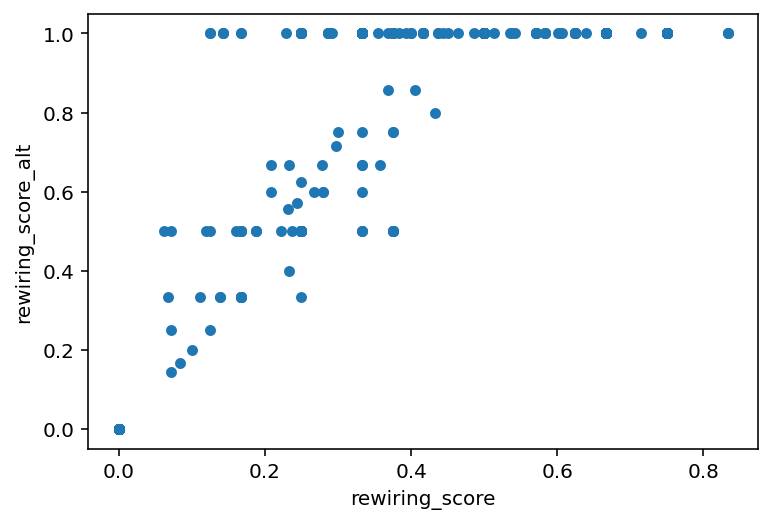

In [9]:
print(partners[['rewiring_score', 'rewiring_score_alt']].corr())
partners.plot.scatter(x='rewiring_score', y='rewiring_score_alt')

In [10]:
cat_columns = [c for c in partners.columns if c.startswith('is_partner_category_')]
partners[cat_columns].sum().sort_values(ascending=False)

is_partner_category_TF                     149
is_partner_category_cofactor                90
is_partner_category_signaling               68
is_partner_category_other                   43
is_partner_category_E3_UBQ                  43
is_partner_category_cytoskeleton            40
is_partner_category_RNA_processing          33
is_partner_category_protein_turnover        27
is_partner_category_metabolism              27
is_partner_category_vesicle_transport       24
is_partner_category_cell_cycle              22
is_partner_category_kinase                  20
is_partner_category_DNA_repair              16
is_partner_category_cell-cell_signaling      9
is_partner_category_translation              8
is_partner_category_RNA_turnover             6
is_partner_category_membrane_protein         3
is_partner_category_DNA_polymerase           3
is_partner_category_nuclear_transport        2
is_partner_category_DNA_replication          2
is_partner_category_protein_traffiking       0
dtype: int64

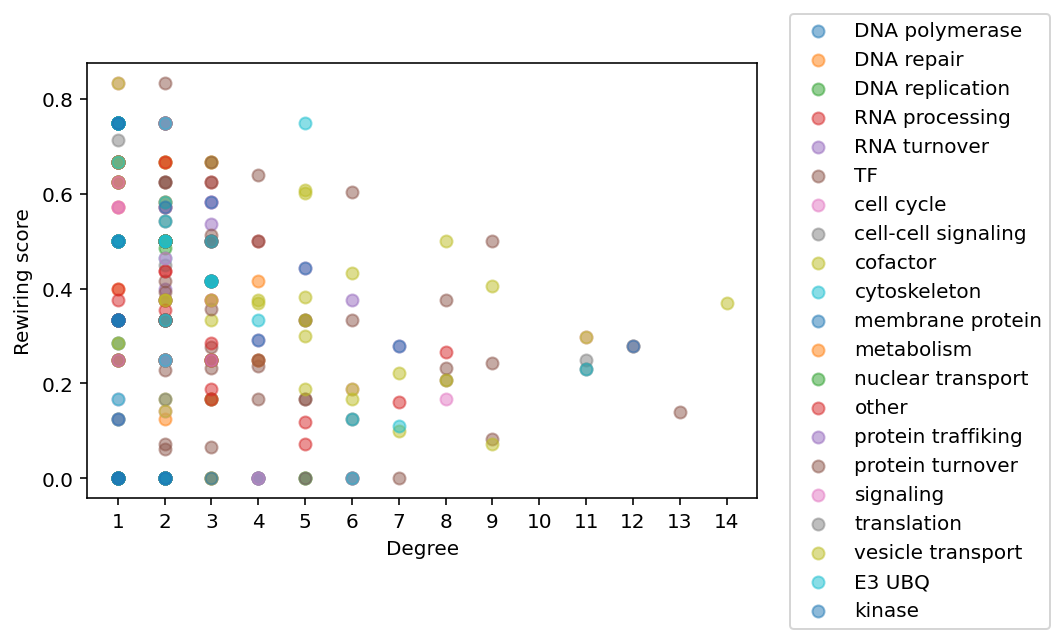

In [11]:
fig, ax = plt.subplots(1, 1)
# order categories by size
for cat in cat_columns:
    ax.scatter(partners.loc[partners[cat],
                             'degree'],
                partners.loc[partners[cat],
                             'rewiring_score'],
               label=cat[len('is_partner_category_'):].replace('_', ' '),
               alpha=0.5)
ax.set_xticks(range(1, partners['degree'].max() + 1))
ax.set_xlabel('Degree')
ax.set_ylabel('Rewiring score')
ax.legend(loc=[1.05, -0.3])

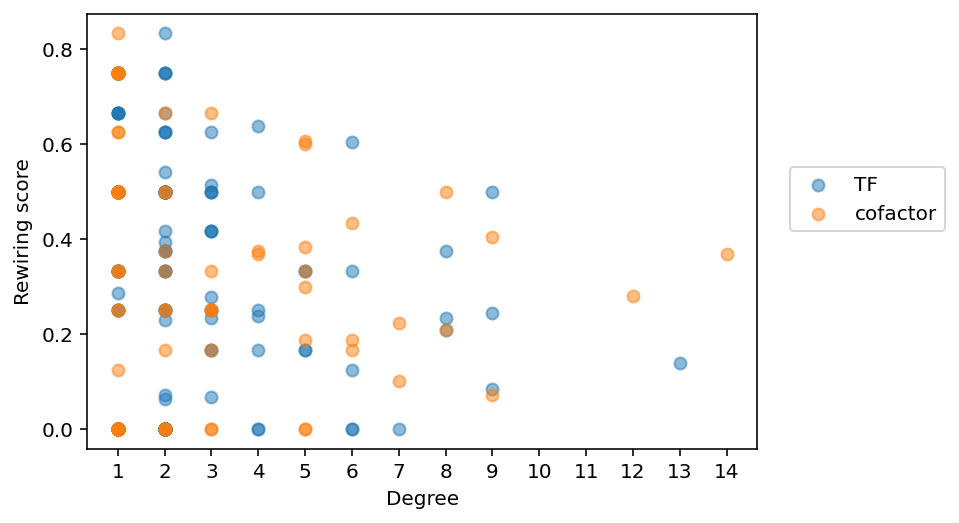

In [12]:
fig, ax = plt.subplots(1, 1)
# order categories by size
min_partners = 75
for cat in cat_columns:
    if partners[cat].sum() < min_partners:
        continue
    ax.scatter(partners.loc[partners[cat],
                             'degree'],
                partners.loc[partners[cat],
                             'rewiring_score'],
               label=cat[len('is_partner_category_'):].replace('_', ' '),
               alpha=0.5)
ax.set_xticks(range(1, partners['degree'].max() + 1))
ax.set_xlabel('Degree')
ax.set_ylabel('Rewiring score')
ax.legend(loc=[1.05, 0.5])

In [13]:
# TEMP: take KRTAPs out of cytoskeleton
partners.loc[partners.index.str.startswith('KRTAP'), 'is_partner_category_cytoskeleton'] = False
partners.loc[partners.index.str.startswith('KRTAP'), 'is_partner_category_other'] = True

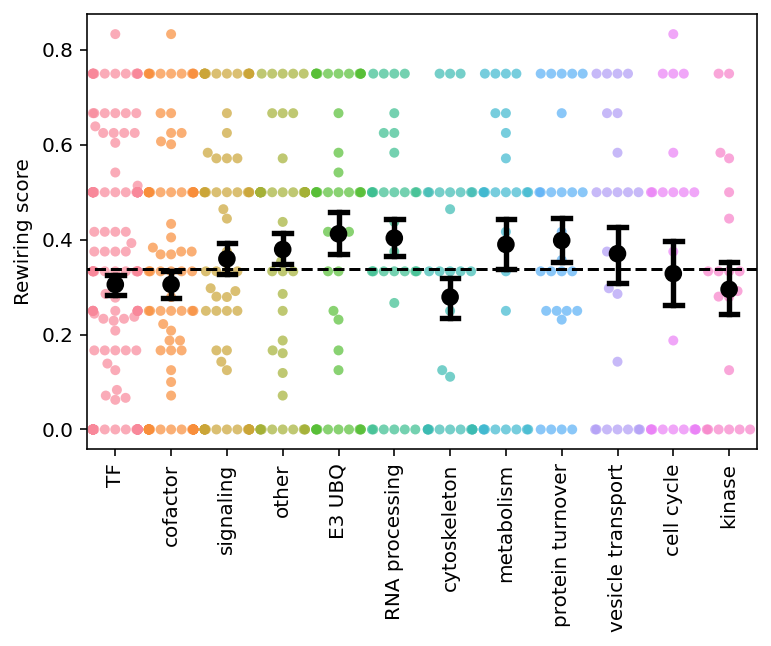

In [14]:
x = partners.loc[:, cat_columns].stack()
x = x[x]
x = x.reset_index(level=1).drop(columns=[0])
x['rewiring_score'] = x.index.map(partners['rewiring_score'])
x = x.rename(columns={'level_1': 'category'})
x['category'] = x['category'].apply(lambda x: x[len('in_partner_category_'):].replace('_', ' '))
min_n_category = 20
x = x[x.groupby('category')['rewiring_score'].transform(lambda x: x.shape[0] >= min_n_category)]
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=x,
              x='category',
              y='rewiring_score',
              order=x.category.value_counts().index.values,
              zorder=-1,
              alpha=0.7,
              ax=ax)
sns.pointplot(data=x,
              x='category',
              y='rewiring_score',
              order=x.category.value_counts().index.values,
              color='black',
              ci=68,
              capsize=0.3,
              linestyles='',
              ax=ax)
ax.axhline(y=partners['rewiring_score'].mean(),
           xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
           linestyle='--', color='black')
#ax.xaxis.set_tick_params(roation=90)
plt.xticks(rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Rewiring score')
plt.savefig('../../figures/rewiring_score_by_category.pdf',
            bbox_inches='tight')

In [15]:
# look at ubiquitin ligases and kinases seperately?
partners[partners.index.str.startswith('TRIM')]

,rewiring_score,rewiring_score_alt,degree,degree_filtered,is_partner_category_DNA_polymerase,is_partner_category_DNA_repair,is_partner_category_DNA_replication,is_partner_category_RNA_processing,is_partner_category_RNA_turnover,is_partner_category_TF,is_partner_category_cell_cycle,is_partner_category_cell-cell_signaling,is_partner_category_cofactor,is_partner_category_cytoskeleton,is_partner_category_membrane_protein,is_partner_category_metabolism,is_partner_category_nuclear_transport,is_partner_category_other,is_partner_category_protein_traffiking,is_partner_category_protein_turnover,is_partner_category_signaling,is_partner_category_translation,is_partner_category_vesicle_transport,is_partner_category_E3_UBQ,is_partner_category_kinase
db_gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,
TRIM21,0.750000,1.0,1,1,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False
TRIM29,0.750000,1.0,1,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
TRIM3,0.000000,0.0,1,1,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False
TRIM38,0.750000,1.0,1,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
TRIM68,0.500000,1.0,1,1,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False
TRIM72,0.666667,1.0,1,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False
TRIML2,0.500000,1.0,1,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


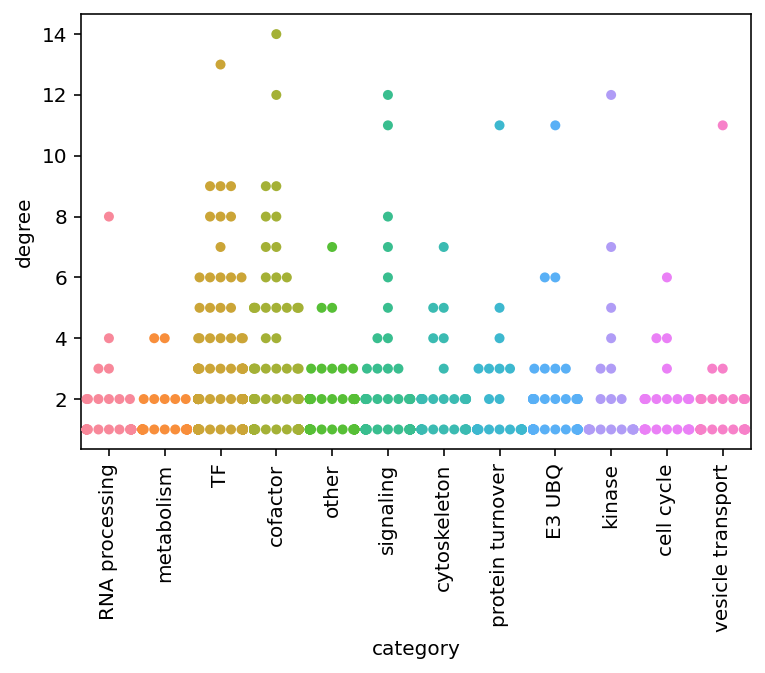

In [16]:
x = partners.loc[:, cat_columns].stack()
x = x[x]
x = x.reset_index(level=1).drop(columns=[0])
x['degree'] = x.index.map(partners['degree'])
x = x.rename(columns={'level_1': 'category'})
x['category'] = x['category'].apply(lambda x: x[len('in_partner_category_'):].replace('_', ' '))
min_n_category = 20
x = x[x.groupby('category')['degree'].transform(lambda x: x.shape[0] >= min_n_category)]
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=x,
              x='category',
              y='degree',
              ax=ax)
#ax.xaxis.set_tick_params(roation=90)
plt.xticks(rotation=90);

In [17]:
partners['rewiring_score_alt'].mean()

0.6601740036542195

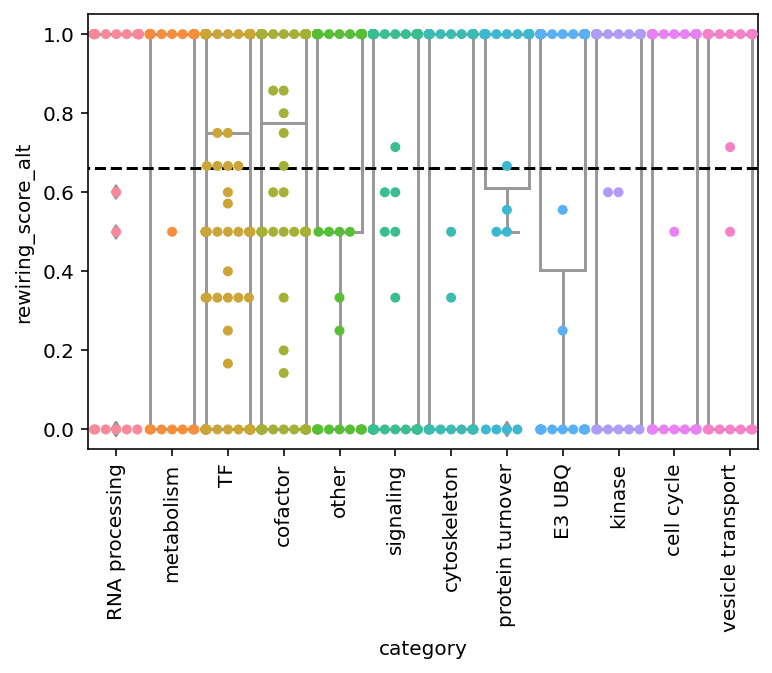

In [18]:
x = partners.loc[:, cat_columns].stack()
x = x[x]
x = x.reset_index(level=1).drop(columns=[0])
x['rewiring_score_alt'] = x.index.map(partners['rewiring_score_alt'])
x = x.rename(columns={'level_1': 'category'})
x['category'] = x['category'].apply(lambda x: x[len('in_partner_category_'):].replace('_', ' '))
min_n_category = 20
x = x[x.groupby('category')['rewiring_score_alt'].transform(lambda x: x.shape[0] >= min_n_category)]
fig, ax = plt.subplots(1, 1)
sns.boxplot(data=x,
              x='category',
              y='rewiring_score_alt',
               color='white',
             ax=ax)
sns.swarmplot(data=x,
              x='category',
              y='rewiring_score_alt',
              ax=ax)
ax.axhline(y=partners['rewiring_score_alt'].mean(),
           xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
           linestyle='--', color='black')
#ax.xaxis.set_tick_params(roation=90)
plt.xticks(rotation=90);

In [19]:
df = pd.read_excel('../../data/internal/20191028- Uniprot functions for interactors.xlsx',
                   sheet_name='Final')
df = df.loc[df['Cofactor type?'].notnull(), ['partner', 'Cofactor type?']]
if df['partner'].duplicated().any():
    raise UserWarning('unexpected duplicates')
cf_type = df.set_index('partner')['Cofactor type?']
x['cofactor_type'] = x.index.map(cf_type)

In [20]:
x[x.category == 'metabolism']

,category,rewiring_score_alt,cofactor_type
db_gene_symbol,,,
ACOT12,metabolism,1.0,NaN
ATP5O,metabolism,1.0,NaN
ATP6V1B2,metabolism,1.0,NaN
ATPAF2,metabolism,0.0,NaN
CBS,metabolism,1.0,NaN
COA5,metabolism,1.0,NaN
COX5B,metabolism,0.0,NaN
FLAD1,metabolism,1.0,NaN
FUCA1,metabolism,0.0,NaN


In [21]:
for cat_col in cat_columns:
    print('{}: {:.4f}'.format(
          cat_col[len('is_partner_category_'):].replace('_', ' '),
          stats.mannwhitneyu(partners.loc[partners[cat_col], 'rewiring_score'].values,
                             partners.loc[~partners[cat_col], 'rewiring_score'].values)[1]))

DNA polymerase: 0.2431
DNA repair: 0.4949
DNA replication: 0.4777
RNA processing: 0.0749
RNA turnover: 0.0229
TF: 0.0383
cell cycle: 0.4556
cell-cell signaling: 0.1830
cofactor: 0.0868
cytoskeleton: 0.0862
membrane protein: 0.3694
metabolism: 0.1249
nuclear transport: 0.2571
other: 0.0949
protein traffiking: 0.0000
protein turnover: 0.1425
signaling: 0.2409
translation: 0.1296
vesicle transport: 0.2501
E3 UBQ: 0.0241
kinase: 0.2075


/Users/lukelambourne/Work/tf_isoforms/venv/lib/python3.7/site-packages/scipy/stats/stats.py:6415: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


In [22]:
tf_fam = load_tf_families()

In [23]:
tf_fam.value_counts()

C2H2 ZF             747
Homeodomain         196
bHLH                108
Unknown              69
bZIP                 54
                   ... 
ARID/BRIGHT; RFX      1
Brinker               1
MBD; CxxC ZF          1
CBF/NF-Y              1
Ets; AT hook          1
Name: DBD, Length: 65, dtype: int64

In [24]:
partners['DBD'] = partners.index.map(tf_fam)

In [25]:
partners.DBD.value_counts()

C2H2 ZF                 46
bHLH                    24
Homeodomain             18
bZIP                    10
Unknown                  7
Nuclear receptor         5
HMG/Sox                  4
E2F                      4
Homeodomain; POU         3
C2H2 ZF; AT hook         3
SMAD                     3
MBD                      3
Ets                      2
THAP finger              2
Forkhead                 2
TCR/CxC                  1
C2H2 ZF; Homeodomain     1
C2H2 ZF; BED ZF          1
DM                       1
CCCH ZF                  1
BED ZF                   1
CENPB                    1
RFX                      1
T-box                    1
Pipsqueak                1
Grainyhead               1
AP-2                     1
TBP                      1
Name: DBD, dtype: int64

In [26]:
partners.loc[partners['DBD'].notnull() & ~partners['DBD'].isin(['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP']), 'DBD'] = 'Other TFs'
partners.loc[partners['DBD'].isnull(), 'DBD'] = 'Not TF'

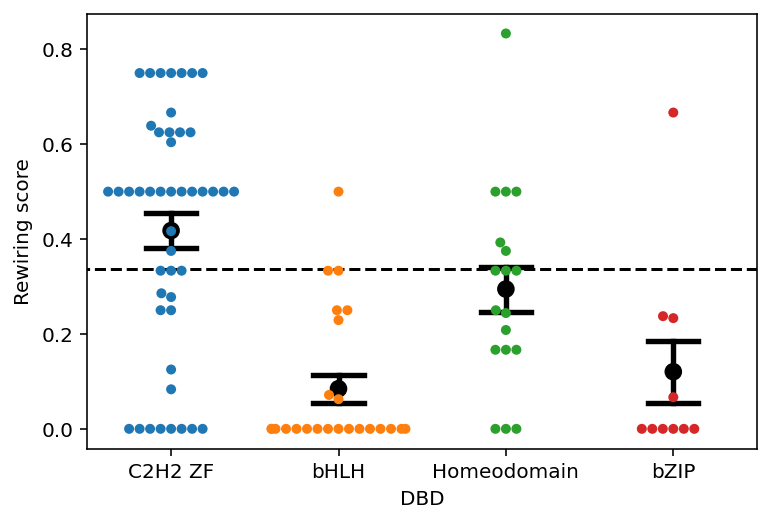

In [35]:
# calculate p-value
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=partners.loc[partners['DBD'].isin(['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP']), :],
            x='DBD',
            y='rewiring_score',
            order=['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP'],
            ax=ax)
sns.pointplot(data=partners.loc[partners['DBD'].isin(['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP']), :],
              x='DBD',
              y='rewiring_score',
              order=['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP'],
              color='black',
              ci=68,
              capsize=0.3,
              linestyles='',
              ax=ax)
ax.axhline(y=partners['rewiring_score'].mean(),
           xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
           linestyle='--', color='black')
ax.set_ylabel('Rewiring score')
plt.savefig('../../figures/rewiring_score_by_DBD.pdf',
            bbox_inches='tight')

In [28]:
# how to calculate a p-value?
# randomly change each partner DBD label? 
#    - Doesn't work because a single bHLH TF can interact with many bHLH

In [29]:
tf_fam.head()

HGNC symbol
TFAP2A    AP-2
TFAP2B    AP-2
TFAP2C    AP-2
TFAP2D    AP-2
TFAP2E    AP-2
Name: DBD, dtype: object

In [30]:
# TF-TF binding
tftf = ppi.loc[ppi['score'] == '1', ['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().copy()
tftf['ad_dbd'] = tftf['ad_gene_symbol'].map(tf_fam)
tftf['db_dbd'] = tftf['db_gene_symbol'].map(tf_fam)
tftf = tftf.dropna()

In [31]:
tftf.loc[tftf['db_dbd'] == 'bHLH', 'ad_gene_symbol'].value_counts()

TCF4      17
TCF12     14
ARNTL2     2
ESRRA      2
ESRRG      1
LHX6       1
FOS        1
ZBTB44     1
ZNF438     1
IKZF2      1
ARNT2      1
Name: ad_gene_symbol, dtype: int64

In [32]:
tftf.loc[(tftf['db_dbd'] == 'bHLH') & (tftf['ad_dbd'] == 'bHLH'), 'ad_gene_symbol'].value_counts()

TCF4      17
TCF12     14
ARNTL2     2
ARNT2      1
Name: ad_gene_symbol, dtype: int64

In [33]:
tftf.loc[tftf['db_dbd'] == 'bZIP', 'ad_gene_symbol'].value_counts()

DDIT3     5
ATF2      3
FOS       2
NFE2L2    2
CREB5     2
FOSB      2
ZNF451    1
NFYA      1
Name: ad_gene_symbol, dtype: int64

In [34]:
# exclude TCF4 and TCF12 and recalculate
partners_mod = (df.loc[~df['ad_gene_symbol'].isin(['TCF4', 'TCF12']), :]
              .groupby(['ad_gene_symbol', 'db_gene_symbol'])['score']
              .mean()
              .reset_index()
              .groupby('db_gene_symbol')
              .mean()
              .rename(columns={'score': 'rewiring_score'}))
partners_mod['rewiring_score'] = 1. - partners_mod['rewiring_score']
partners_mod['DBD'] = partners_mod.index.map(tf_fam)

fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=partners_mod.loc[partners_mod['DBD'].isin(['C2H2 ZF', 'bHLH']), :],
            x='DBD',
            y='rewiring_score',
            order=['C2H2 ZF', 'bHLH'],
            ax=ax)
sns.pointplot(data=partners_mod.loc[partners_mod['DBD'].isin(['C2H2 ZF', 'bHLH']), :],
              x='DBD',
              y='rewiring_score',
              order=['C2H2 ZF', 'bHLH'],
              color='black',
              ci=68,
              capsize=0.3,
              linestyles='',
              ax=ax)
ax.set_ylabel('Rewiring score')
plt.savefig('../../figures/rewiring_score_by_DBD_exclude_TCF4_TCF12.pdf',
            bbox_inches='tight')

stats.mannwhitneyu(partners_mod.loc[partners_mod['DBD'] == 'C2H2 ZF', 'rewiring_score'].values,
                   partners_mod.loc[partners_mod['DBD'] == 'bHLH', 'rewiring_score'].values)[1] * 6

KeyError: 'ad_gene_symbol'

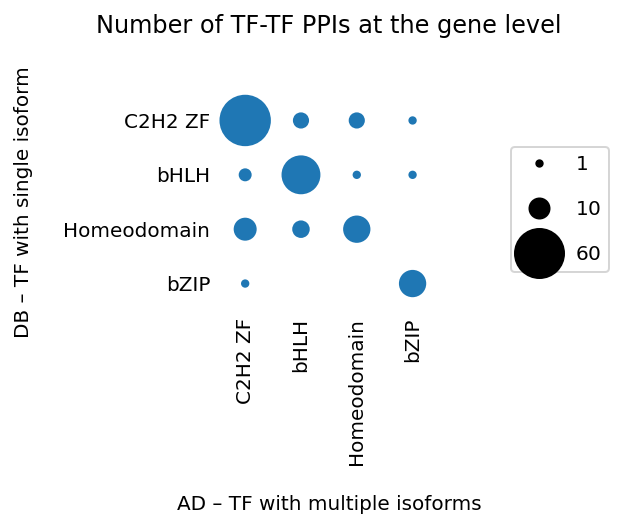

In [73]:
fams = tf_fam.unique()
fams = ['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP']
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, 2)
scaling = 10
sc = ax.scatter(x=[x for x in fams for y in fams],
           y=[y for x in fams for y in fams],
           s=[((tftf['ad_dbd'] == x) & (tftf['db_dbd'] == y)).sum() * scaling for x in fams for y in fams],
           clip_on=False)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0, rotation=90)
for s in ax.spines.values():
    s.set_visible(False)
ax.set_xlim(-0.5, len(fams) - 0.5)
ax.set_ylim(len(fams) - 0.5, -0.5)
ax.set_xlabel('AD – TF with multiple isoforms',
              labelpad=15)
ax.set_ylabel('DB – TF with single isoform',
              labelpad=15)
ax.set_title('Number of TF-TF PPIs at the gene level',
             pad=30)
ax.legend(*sc.legend_elements('sizes',
                              num=[1, 10, 60],
                              func=lambda x: x / scaling),
          bbox_to_anchor=[1.8, 0.8],
         labelspacing=1.3)
plt.savefig('../../figures/TF_TF_correlogram.pdf', bbox_inches='tight')

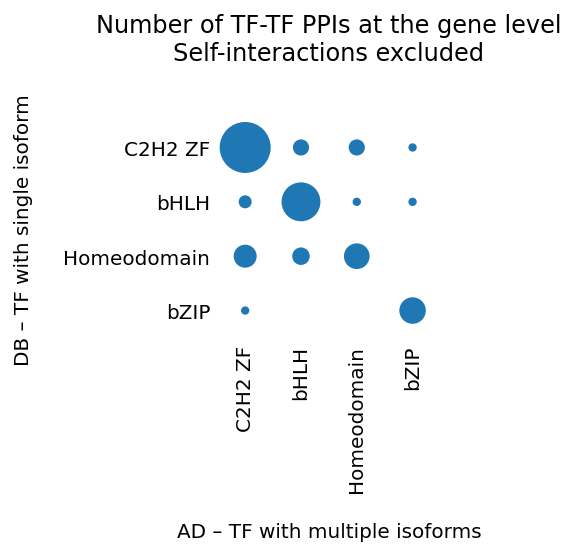

In [74]:
# homodimers excluded
fams = tf_fam.unique()
fams = ['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP']
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, 2)
scaling = 10
ax.scatter(x=[x for x in fams for y in fams],
           y=[y for x in fams for y in fams],
           s=[((tftf['ad_dbd'] == x) & (tftf['db_dbd'] == y) & (tftf['ad_gene_symbol'] != tftf['db_gene_symbol'])).sum() * scaling for x in fams for y in fams],
           clip_on=False)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0, rotation=90)
for s in ax.spines.values():
    s.set_visible(False)
ax.set_xlim(-0.5, len(fams) - 0.5)
ax.set_ylim(len(fams) - 0.5, -0.5)
ax.set_xlabel('AD – TF with multiple isoforms',
              labelpad=15)
ax.set_ylabel('DB – TF with single isoform',
              labelpad=15)
ax.set_title('Number of TF-TF PPIs at the gene level\nSelf-interactions excluded',
             pad=30)
plt.savefig('../../figures/TF_TF_correlogram_homodimers_excluded.pdf', bbox_inches='tight')

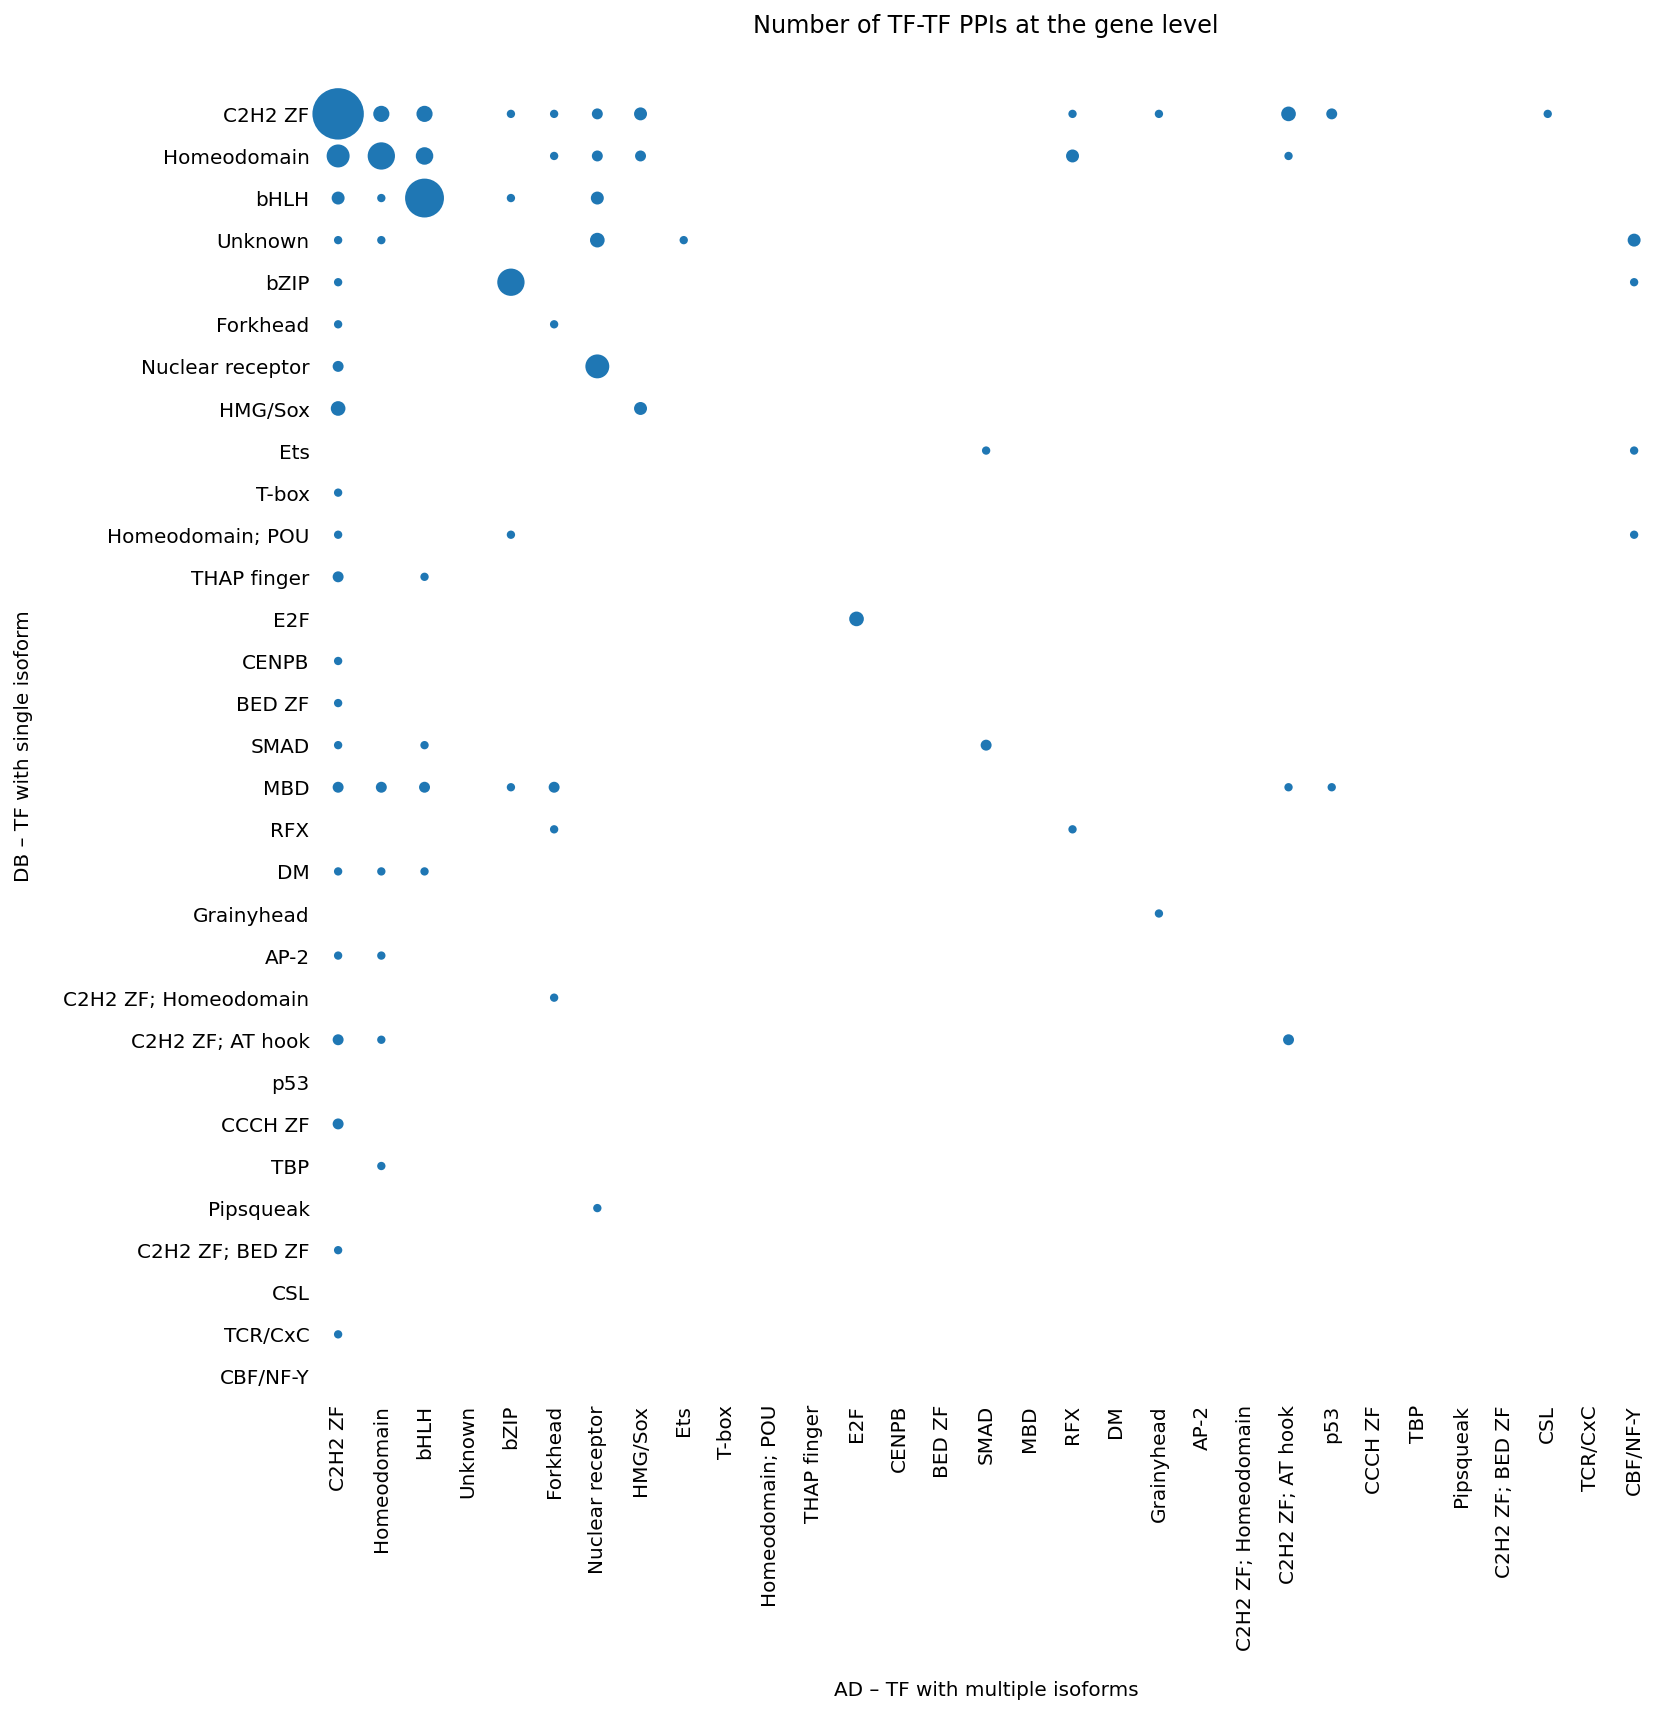

In [75]:
# all families
fams = tf_fam.value_counts().index
fams = list(filter(lambda x: x in tftf['ad_dbd'].unique() or x in tftf['db_dbd'].unique(), fams))
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 12)
scaling = 10
ax.scatter(x=[x for x in fams for y in fams],
           y=[y for x in fams for y in fams],
           s=[((tftf['ad_dbd'] == x) & (tftf['db_dbd'] == y)).sum() * scaling for x in fams for y in fams],
           clip_on=False)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0, rotation=90)
for s in ax.spines.values():
    s.set_visible(False)
ax.set_xlim(-0.5, len(fams) - 0.5)
ax.set_ylim(len(fams) - 0.5, -0.5)
ax.set_xlabel('AD – TF with multiple isoforms',
              labelpad=15)
ax.set_ylabel('DB – TF with single isoform',
              labelpad=15)
ax.set_title('Number of TF-TF PPIs at the gene level',
             pad=30)
plt.savefig('../../figures/TF_TF_correlogram_all.pdf', bbox_inches='tight')

In [76]:
# examples
# ZBTB48
# ZSCAN12
# FIGLA - TCF12, TCF4, LHX6, 
# MSGN1
partners.loc[partners['DBD'] == 'C2H2 ZF', :].sort_values(['rewiring_score', 'degree_filtered'], ascending=[True, False]).head(5)

,rewiring_score,rewiring_score_alt,degree,degree_filtered,is_partner_category_DNA_polymerase,is_partner_category_DNA_repair,is_partner_category_DNA_replication,is_partner_category_RNA_processing,is_partner_category_RNA_turnover,is_partner_category_TF,is_partner_category_cell_cycle,is_partner_category_cell-cell_signaling,is_partner_category_cofactor,is_partner_category_cytoskeleton,is_partner_category_membrane_protein,is_partner_category_metabolism,is_partner_category_nuclear_transport,is_partner_category_other,is_partner_category_protein_traffiking,is_partner_category_protein_turnover,is_partner_category_signaling,is_partner_category_translation,is_partner_category_vesicle_transport,is_partner_category_E3_UBQ,is_partner_category_kinase,DBD
db_gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,
ZBTB25,0.0,0.0,6,3,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,C2H2 ZF
ZNF250,0.0,0.0,7,3,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,C2H2 ZF
IKZF1,0.0,0.0,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,C2H2 ZF
YY1,0.0,0.0,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,C2H2 ZF
ZBTB2,0.0,0.0,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,C2H2 ZF


In [77]:
ppi.loc[ppi['db_gene_symbol'] == 'FIGLA', 'ad_gene_symbol'].unique()

array(['TCF12', 'TCF4', 'LHX6'], dtype=object)

In [78]:
ppi.loc[ppi['db_gene_symbol'] == 'MSGN1', 'ad_gene_symbol'].unique()

array(['TCF4', 'ESRRA', 'TCF12'], dtype=object)

In [79]:
ppi.loc[ppi['db_gene_symbol'] == 'ZSCAN12', 'ad_gene_symbol'].unique()

array(['ZNF451', 'ZNF397'], dtype=object)

In [80]:
# statisitcal test (6 is Bonferonni for all pairwise)
# problem with this is that the points are not necessarily indepedent: could all be binding to same TF
stats.mannwhitneyu(partners.loc[partners['DBD'] == 'C2H2 ZF', 'rewiring_score'].values,
                   partners.loc[partners['DBD'] == 'bHLH', 'rewiring_score'].values)[1] * 6

3.491707433580842e-06

In [81]:
stats.mannwhitneyu(partners.loc[(partners['DBD'] == 'C2H2 ZF')
                                & (partners['degree'] == 1),
                                'rewiring_score'].values,
                   partners.loc[(partners['DBD'] == 'bZIP')
                                 & (partners['degree'] == 1),
                                'rewiring_score'].values)

MannwhitneyuResult(statistic=19.5, pvalue=0.034154173044924664)

In [82]:
partners.head()

,rewiring_score,rewiring_score_alt,degree,degree_filtered,is_partner_category_DNA_polymerase,is_partner_category_DNA_repair,is_partner_category_DNA_replication,is_partner_category_RNA_processing,is_partner_category_RNA_turnover,is_partner_category_TF,is_partner_category_cell_cycle,is_partner_category_cell-cell_signaling,is_partner_category_cofactor,is_partner_category_cytoskeleton,is_partner_category_membrane_protein,is_partner_category_metabolism,is_partner_category_nuclear_transport,is_partner_category_other,is_partner_category_protein_traffiking,is_partner_category_protein_turnover,is_partner_category_signaling,is_partner_category_translation,is_partner_category_vesicle_transport,is_partner_category_E3_UBQ,is_partner_category_kinase,DBD
db_gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,
A1CF,0.500000,1.000000,1,1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Not TF
ACOT12,0.750000,1.000000,2,1,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,Not TF
AEBP2,0.333333,1.000000,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,C2H2 ZF
AES,0.369048,0.857143,14,7,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,Not TF
AGR2,0.500000,1.000000,1,1,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,Not TF


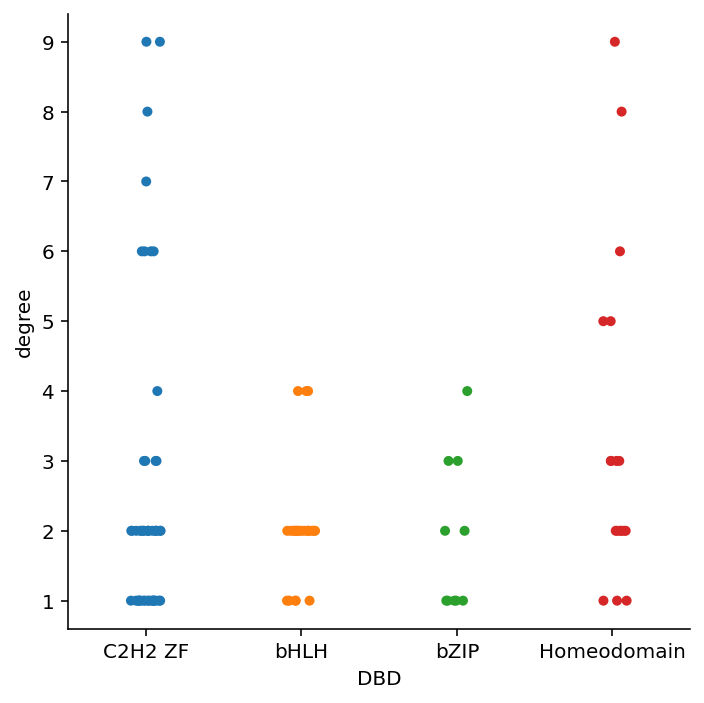

In [83]:
# is it a degree thing?
sns.catplot(data=partners.loc[partners['DBD'].isin(['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP']), :],
            x='DBD', y='degree')

In [84]:
# could take an example of very reqired ZF

In [85]:
# Is it that ZF are more rewired or the others are less, or both?



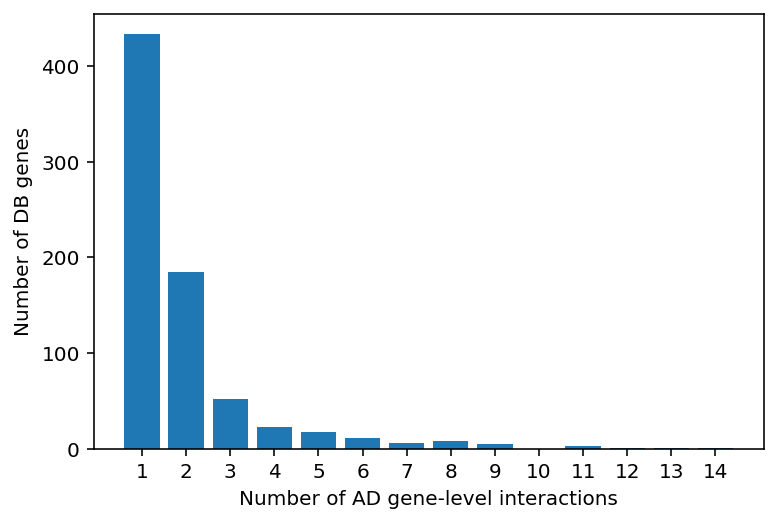

In [86]:
partner_degree = (y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                          (y2h['score'] == '1'),
                          ['ad_gene_symbol', 'db_gene_symbol']]
                     .groupby('db_gene_symbol')
                     ['ad_gene_symbol']
                     .nunique())

fig, ax = plt.subplots(1, 1)
db_deg = partner_degree.value_counts()
plt.bar(db_deg.index.values, db_deg.values)
ax.set_xticks(range(1, partner_degree.max() + 1))
ax.set_ylabel('Number of DB genes')
ax.set_xlabel('Number of AD gene-level interactions')
plt.savefig('../../figures/DB_gene_level_degree.pdf',
            bbox_inches='tight')

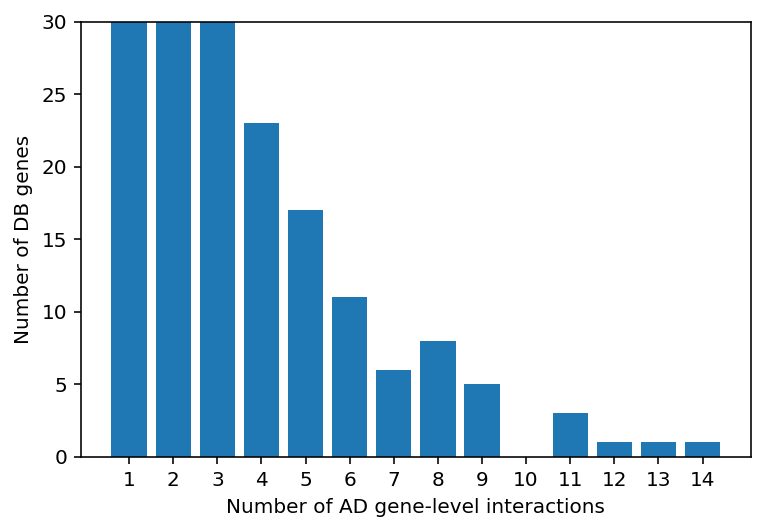

In [87]:
fig, ax = plt.subplots(1, 1)
ax.bar(db_deg.index.values, db_deg.values)
ax.set_xticks(range(1, partner_degree.max() + 1))
ax.set_ylabel('Number of DB genes')
ax.set_xlabel('Number of AD gene-level interactions')
ax.set_ylim(0, 30)
plt.savefig('../../figures/DB_gene_level_degree_zoom.pdf',
            bbox_inches='tight')

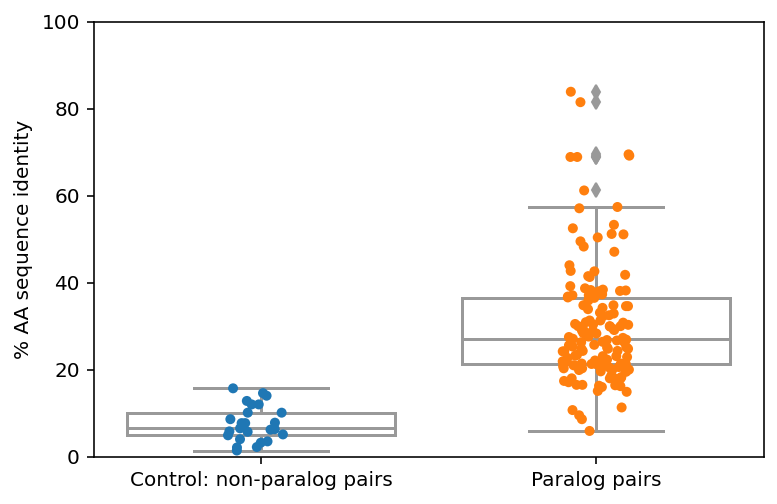

In [88]:
fig, ax = plt.subplots(1, 1)
sns.stripplot(data=pairs, x='is_paralog_pair', y='pct_aa_seq_identity')
sns.boxplot(data=pairs, x='is_paralog_pair', y='pct_aa_seq_identity', color='white')
ax.set_ylim(0, 100)
ax.set_ylabel('% AA sequence identity')
ax.set_xticklabels(['Control: non-paralog pairs', 'Paralog pairs'])
ax.set_xlabel('')
plt.savefig('../../figures/paralog_nonparalog_aa_identity.pdf',
            bbox_inches='tight')

KeyboardInterrupt: 

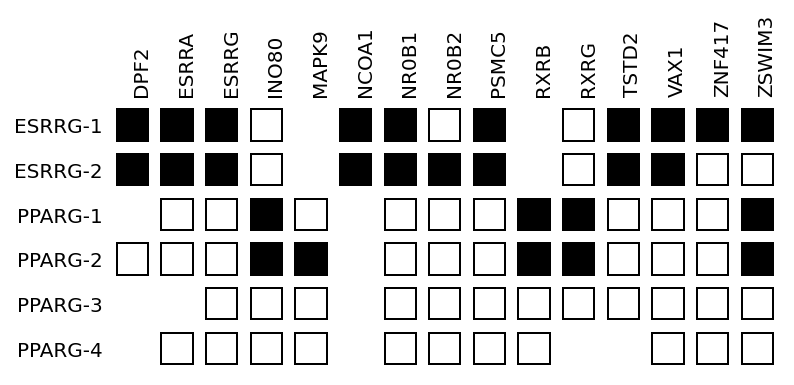

In [89]:
# Takes a long time
for i, row in pairs.iterrows():
    fig, ax = plt.subplots(1, 1)
    a = row['tf_gene_a']
    b = row['tf_gene_b']
    y2h_ppi_per_paralog_pair_plot(a, b, y2h, ax=ax)
    os.makedirs('../../figures/paralog_pairs', exist_ok=True)
    plt.savefig('../../figures/paralog_pairs/' + a + '_' + b + '.pdf',
                bbox_inches='tight')
    plt.close(fig)

In [90]:
#    - How many partners were negative in all pairwise tests?
a = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'),
           'db_gene_symbol'].nunique()
b = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
           (y2h['score'] == '1'),
           'db_gene_symbol'].nunique()
print('Of {} tested partners, {} had at least one positive result'.format(a, b))

Of 907 tested partners, 746 had at least one positive result


In [91]:
a = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'),
           'db_gene_symbol'].unique()
b = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
           (y2h['score'] == '1'),
           'db_gene_symbol'].unique()
c = set(a).difference(set(b))
# remove these interactions where none of the isoforms are positive
y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
        y2h['db_gene_symbol'].isin(c), :].head()

,category,ad_orf_id,ad_clone_acc,ad_gene_symbol,db_orf_id,db_gene_symbol,score,standard_batch,retest_pla,retest_pos,in_orfeome_screen,in_focussed_screen,in_hi_union,in_lit_bm,is_partner_category_DNA_polymerase,is_partner_category_DNA_repair,is_partner_category_DNA_replication,is_partner_category_RNA_processing,is_partner_category_RNA_turnover,is_partner_category_TF,is_partner_category_cell_cycle,is_partner_category_cell-cell_signaling,is_partner_category_cofactor,is_partner_category_cytoskeleton,is_partner_category_membrane_protein,is_partner_category_metabolism,is_partner_category_nuclear_transport,is_partner_category_other,is_partner_category_protein_traffiking,is_partner_category_protein_turnover,is_partner_category_signaling,is_partner_category_translation,is_partner_category_vesicle_transport,is_cofactor_subtype_both,is_cofactor_subtype_coactivator,is_cofactor_subtype_corepressor,is_cofactor_subtype_unknown
57,tf_isoform_ppis,101216,GATA1|1/2|08A02,GATA1,1579,TEKT4,0,TFr11,1,A07,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
103,tf_isoform_ppis,100301,SMAD3|1/4|06A07,SMAD3,1579,TEKT4,0,TFr07,2,B01,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
115,tf_isoform_ppis,100697,SMAD3|4/4|06F07,SMAD3,1579,TEKT4,0,TFr07,2,C01,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
126,tf_isoform_ppis,100657,SMAD3|2/4|06G07,SMAD3,1579,TEKT4,0,TFr07,2,D01,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
138,tf_isoform_ppis,100479,SMAD3|3/4|06B08,SMAD3,1579,TEKT4,0,TFr09,1,G06,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [92]:
print('Total TF genes with cloned isoforms: {}'.format(isoforms['gene'].nunique()))
print('Total TF genes with 2+ cloned isoforms: {}'.format(sum((isoforms.groupby('gene').count()>1)['clone_acc'])))
print('with ≥ 1 PPI: {}'.format(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                                        (y2h['score'] == '1'), 
                                        'ad_gene_symbol'].nunique()))
print('with ≥ 2 isoforms with ≥ 1 successuful PPI test for the same partner: {}'
       .format(
        (((y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                   y2h['score'].isin(['0', '1']), 
                   :]
              .groupby(['ad_gene_symbol', 'db_gene_symbol'])
              ['ad_clone_acc']
              .nunique() # number of isoforms per partner with valid interactions
              >= 2)
              .reset_index()
              .groupby('ad_gene_symbol').sum() >= 2).sum().iat[0])
     )
)
print('with ≥ 2 isoforms with ≥ 1 PPI each: {}'
       .format(
          (y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                   (y2h['score'] == '1'), 
                   :]
              .groupby('ad_gene_symbol')
              ['ad_clone_acc']
              .nunique()
              >= 2).sum()  
         )
     )

Total TF genes with cloned isoforms: 312
Total TF genes with 2+ cloned isoforms: 249
with ≥ 1 PPI: 132
with ≥ 2 isoforms with ≥ 1 successuful PPI test for the same partner: 89
with ≥ 2 isoforms with ≥ 1 PPI each: 71


In [93]:
print('Total TF isoforms: {}'.format(isoforms['clone_acc'].nunique()))
print('with ≥ 1 PPI: {}'.format(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                                        (y2h['score'] == '1'), 
                                        'ad_clone_acc'].nunique()))
print('with ≥ 1 successfully tested PPI: {}'.format(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                                                    y2h['score'].isin(['0', '1']), 
                                                    'ad_clone_acc'].nunique()))

Total TF isoforms: 762
with ≥ 1 PPI: 241
with ≥ 1 successfully tested PPI: 378


In [94]:
ppi.head()

,ad_clone_acc,ad_gene_symbol,db_gene_symbol,score
3,TCF4|8/9|07A05,TCF4,HOXA1,NC
4,ZBTB16|2/2|01D03,ZBTB16,HOXA1,NC
7,HMBOX1|1/5|03A07,HMBOX1,SCNM1,1
13,TCF4|1/9|07E01,TCF4,HOXA1,1
17,ARNT2|2/6|09E01,ARNT2,SCNM1,0


In [95]:
(ppi.shape[0],
 ppi['ad_gene_symbol'].nunique(),
 ppi['ad_clone_acc'].nunique(),
 ppi['db_gene_symbol'].nunique())

(3332, 71, 180, 556)

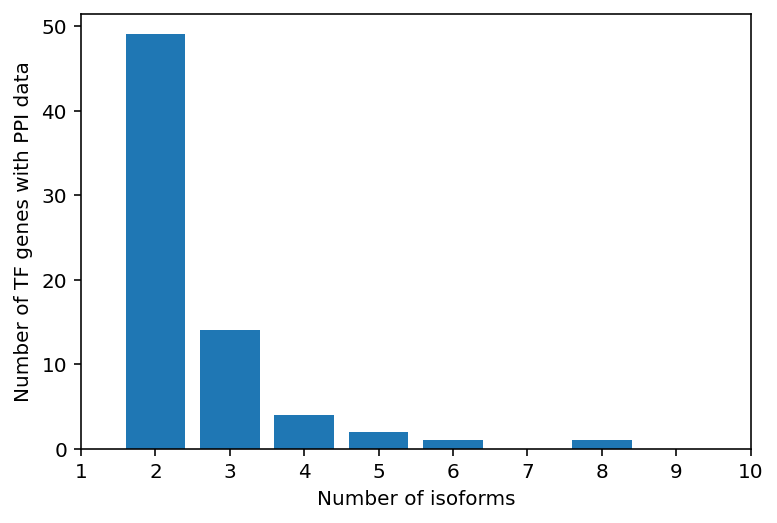

In [96]:
#    - Number of isoforms per TF gene

# remove isoform counts of 1?
n_iso = ppi.groupby('ad_gene_symbol').nunique()['ad_clone_acc']
fig, ax = plt.subplots(1, 1)
ax.bar(n_iso.value_counts().index,
       n_iso.value_counts().values)
ax.set_xticks(range(1, 11))
ax.set_xlabel('Number of isoforms')
ax.set_ylabel('Number of TF genes with PPI data')
plt.savefig('../../figures/n_isoforms_per_gene_with_ppi_data.pdf',
            bbox_inches='tight')

In [97]:
ppi.groupby('ad_gene_symbol').nunique()['db_gene_symbol'].max()

166

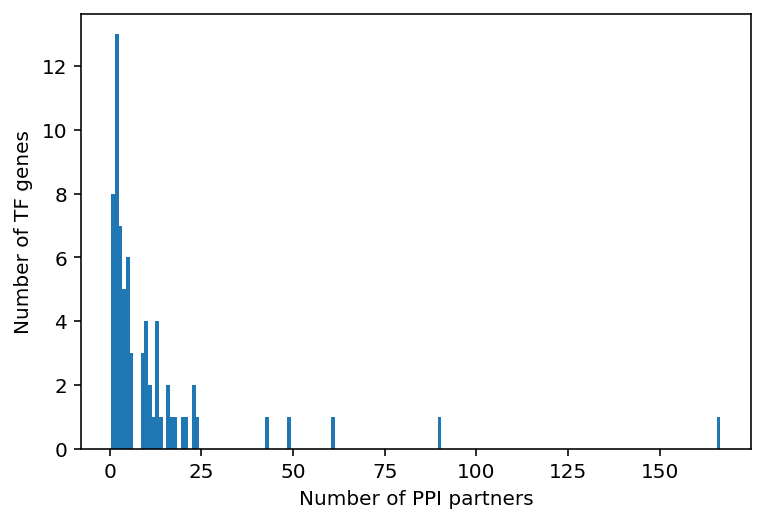

In [98]:
n_ppi = ppi.groupby('ad_gene_symbol').nunique()['db_gene_symbol']
fig, ax = plt.subplots(1, 1)
ax.hist(n_ppi.values, range=(0.5, n_ppi.max() + 0.5), bins=n_ppi.max())
ax.set_xlabel('Number of PPI partners')
ax.set_ylabel('Number of TF genes')
plt.savefig('../../figures/tf_gene_degree.pdf')

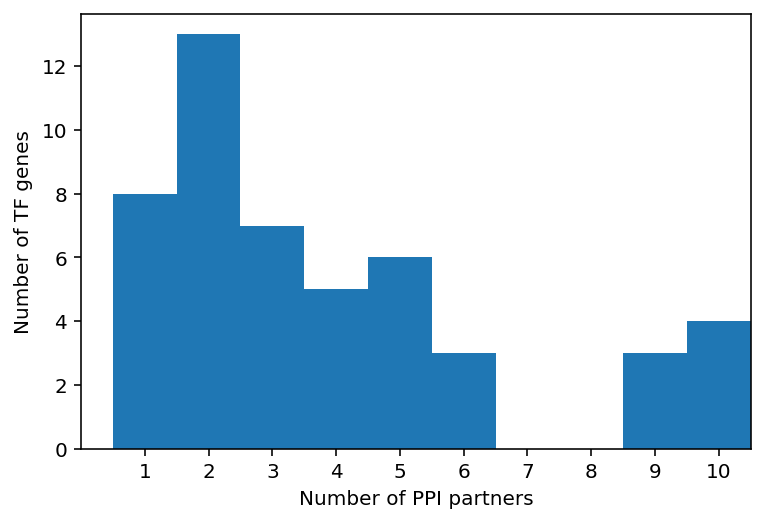

In [99]:
n_ppi = ppi.groupby('ad_gene_symbol').nunique()['db_gene_symbol']
fig, ax = plt.subplots(1, 1)
ax.hist(n_ppi.values, range=(0.5, n_ppi.max() + 0.5), bins=n_ppi.max())
ax.set_xlabel('Number of PPI partners')
ax.set_ylabel('Number of TF genes')
ax.set_xlim(0, 10.5)
ax.set_xticks(range(1, 11))
plt.savefig('../../figures/tf_gene_degree_zoom.pdf')

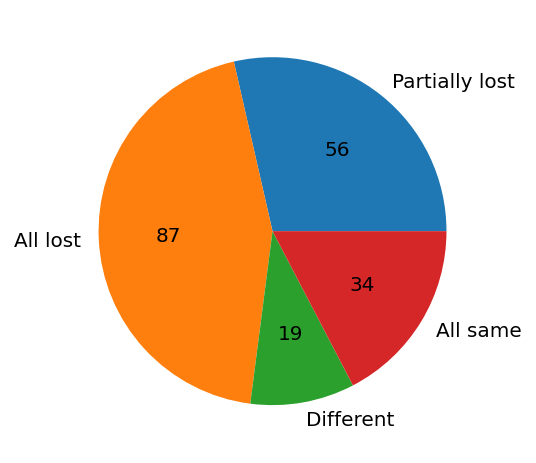

In [112]:
require_at_least_one_ppi_alt_per_isoform = False
ppi_alt = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'), 
              ['ad_clone_acc',
               'ad_gene_symbol',
               'db_gene_symbol',
               'score']].copy()
ppi_alt = ppi_alt.loc[ppi_alt.groupby(['ad_gene_symbol', 'db_gene_symbol'])
                 ['score']
                 .transform(lambda row: (row == '1').any()),
              :]
ppi_alt = ppi_alt.loc[ppi_alt.groupby('ad_clone_acc')
                  ['score']
                  .transform(lambda x: (x.isin(['0', '1']).any())),
              :]
if require_at_least_one_ppi_alt_per_isoform:
    ppi_alt = ppi_alt.loc[ppi_alt.groupby('ad_clone_acc')['score'].transform(lambda x: (x == '1').any()),
                  :]
ppi_alt = ppi_alt.loc[ppi_alt.groupby('ad_gene_symbol')
                 ['ad_clone_acc']
                 .transform(lambda x: x.nunique() >= 2),
              :]
cats = []
for gene_name in ppi_alt['ad_gene_symbol'].unique():
    tf = ppi_alt.loc[(ppi_alt['ad_gene_symbol'] == gene_name),
                ['ad_clone_acc', 'db_gene_symbol', 'score']].copy()
    tf['score'] = tf['score'].map({'1': True,
                               '0': False,
                               'AA': np.nan,
                               'NC': np.nan})
    tf = tf.pivot(index='ad_clone_acc',
                  columns='db_gene_symbol',
                  values='score')
    ref_iso = tf.sum(axis=1).idxmax()
    for iso in tf.index:
        if iso == ref_iso:
            continue
        subset = tf.loc[[ref_iso, iso], 
                        tf.loc[ref_iso, :].notnull() &
                        tf.loc[iso, :].notnull()]    
        if (subset.loc[ref_iso, :] == subset.loc[iso, :]).all():
            cats.append('All same')
        elif subset.loc[iso, subset.columns[subset.loc[ref_iso, :] != True]].any():
            cats.append('Different')
        elif not subset.loc[iso, :].any():
            cats.append('All lost')
        else:
            cats.append('Partially lost')
counts = Counter(cats)
plt.pie(counts.values(),
        labels=counts.keys(),
        autopct=lambda x: '{:.0f}'.format((x / 100.) * sum(counts.values())))
plt.savefig('../../figures/alt_isoforms_ppi_alts_pie_inc_no_ppi_alt.pdf',
            bbox_inches='tight')

In [100]:
# classify alternative isoforms by comparing to one with the most interactions
#    (1) all the same 
#    (2) none of those interactions and no others 
#    (3) some of those interactions
#    (4) some additional interactions
# minimum # interactions ?
# this kind-of works but has issues when the ppi with most interacions is tied and there is 

cats = []
for gene_name in ppi['ad_gene_symbol'].unique():
    tf = ppi.loc[(ppi['ad_gene_symbol'] == gene_name),
                ['ad_clone_acc', 'db_gene_symbol', 'score']].copy()
    tf['score'] = tf['score'].map({'1': True,
                               '0': False,
                               'AA': np.nan,
                               'NC': np.nan})
    tf = tf.pivot(index='ad_clone_acc',
                  columns='db_gene_symbol',
                  values='score')
    ref_iso = tf.sum(axis=1).idxmax()
    for iso in tf.index:
        if iso == ref_iso:
            continue
        subset = tf.loc[[ref_iso, iso], 
                        tf.loc[ref_iso, :].notnull() &
                        tf.loc[iso, :].notnull()]    
        if (subset.loc[ref_iso, :] == subset.loc[iso, :]).all():
            cats.append('All same')
        elif subset.loc[iso, subset.columns[subset.loc[ref_iso, :] != True]].any():
            cats.append('Different')
        elif not subset.loc[iso, :].any():
            cats.append('All lost')
        else:
            cats.append('Partially lost')


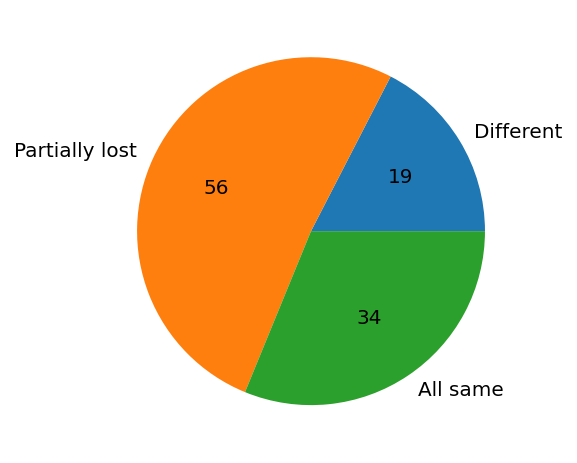

In [101]:
counts = Counter(cats)
plt.pie(counts.values(),
        labels=counts.keys(),
        autopct=lambda x: '{:.0f}'.format((x / 100.) * sum(counts.values())))
plt.savefig('../../figures/alt_isoforms_ppis_pie.pdf',
            bbox_inches='tight')

In [102]:
# rewiring fraction
# add category


partners = (ppi.loc[(ppi['score'] == '1'),
                          ['ad_gene_symbol', 'db_gene_symbol']]
                     .groupby('db_gene_symbol')
                     ['ad_gene_symbol']
                     .nunique()).rename('degree_gene_level').to_frame()

df = ppi.copy()
df['score'] = df['score'].map({'1': 1,
                               '0': 0,
                               'AA': np.nan,
                               'NC': np.nan})
# require at least two successful isoform tests per ad gene
df = df.loc[df.groupby(['ad_gene_symbol', 'db_gene_symbol'])
              ['score']
              .transform(lambda x: x.notnull().sum() >= 2),
            :]
partners['rewiring_score'] = 1 - (df.groupby(['ad_gene_symbol', 'db_gene_symbol'])
                                     ['score'].mean().reset_index().groupby('db_gene_symbol').mean())
partners = partners.dropna(subset=['rewiring_score'])
partners.head()

,degree_gene_level,rewiring_score
db_gene_symbol,,
A1CF,1,0.500000
ACOT12,1,0.750000
AEBP2,1,0.333333
AES,7,0.369048
AGR2,1,0.500000


SpearmanrResult(correlation=-0.19278186978613085, pvalue=6.176900285955131e-06)


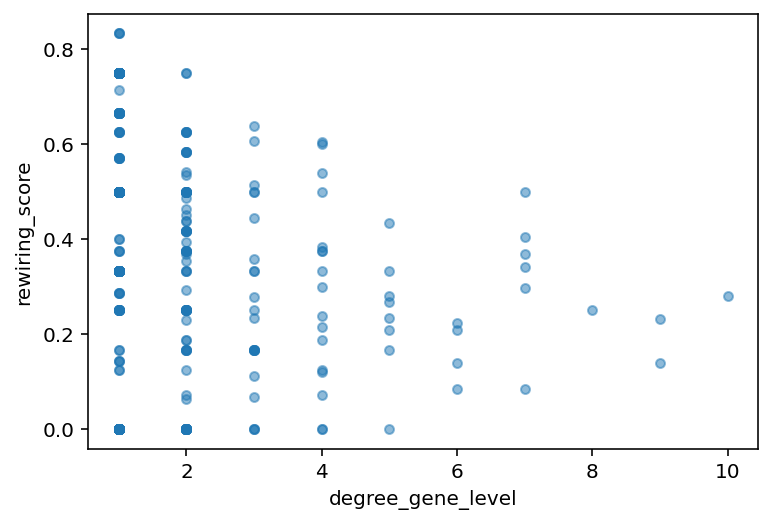

In [103]:

print(stats.spearmanr(partners['degree_gene_level'].values, partners['rewiring_score']))
partners.plot.scatter(x='degree_gene_level', 
                      y='rewiring_score',
                      alpha=0.5)

In [104]:
partners.sort_values('rewiring_score', ascending=False)

,degree_gene_level,rewiring_score
db_gene_symbol,,
SIX1,1,0.833333
SPO11,1,0.833333
CRY2,1,0.833333
LCE2C,1,0.750000
TRAF3IP3,1,0.750000
...,...,...
RPL22,1,0.000000
TNS2,1,0.000000
TNNT1,1,0.000000


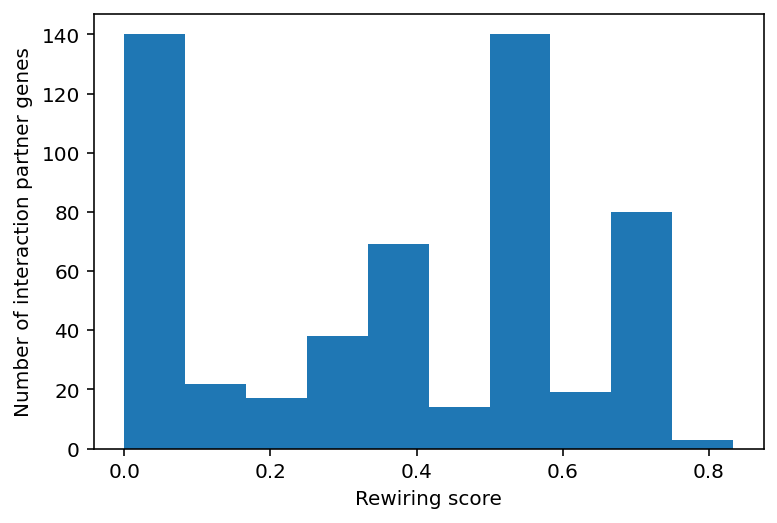

In [105]:
fig, ax = plt.subplots(1, 1)
partners['rewiring_score'].plot.hist()
ax.set_xlabel('Rewiring score')
ax.set_ylabel('Number of interaction partner genes')
plt.savefig('../../figures/rewiring_dist.pdf',
            bbox_inches='tight')

In [106]:
partner_cats = load_ppi_partner_categories()
partner_cats.head()

,partner,category,cofactor_type
0,CITED2,cofactor,both
1,DPF2,cofactor,both
2,EMSY,cofactor,both
3,FHL2,cofactor,both
4,HR,cofactor,both


In [107]:
cats = partner_cats.groupby('category')['partner'].apply(set).to_dict()
for cat, members in cats.items():
    partners['is_' + '_'.join(cat.split())] = partners.index.isin(members)

In [108]:
for col in partners.columns:
    if col.startswith('is_'):
        print(col)
        print(stats.mannwhitneyu(partners.loc[partners[col], 'rewiring_score'].values,
                                 partners.loc[~partners[col], 'rewiring_score'].values))

is_DNA_polymerase
MannwhitneyuResult(statistic=651.0, pvalue=0.27765939169545945)
is_DNA_repair
MannwhitneyuResult(statistic=4092.5, pvalue=0.4249013378290839)
is_DNA_replication
MannwhitneyuResult(statistic=519.0, pvalue=0.4624615498913629)
is_RNA_processing
MannwhitneyuResult(statistic=7410.0, pvalue=0.12473941718494491)
is_RNA_turnover
MannwhitneyuResult(statistic=898.0, pvalue=0.02937919953752668)
is_TF
MannwhitneyuResult(statistic=26253.0, pvalue=0.05565398369912887)
is_cell_cycle
MannwhitneyuResult(statistic=5518.0, pvalue=0.38797685898624273)
is_cell-cell_signaling
MannwhitneyuResult(statistic=1921.0, pvalue=0.14907713626596497)
is_cofactor
MannwhitneyuResult(statistic=18074.5, pvalue=0.05849534156206088)
is_cytoskeleton
MannwhitneyuResult(statistic=8943.5, pvalue=0.4271783343585338)
is_membrane_protein
MannwhitneyuResult(statistic=735.5, pvalue=0.3926710841613553)
is_metabolism
MannwhitneyuResult(statistic=5764.0, pvalue=0.10924678202297078)
is_nuclear_transport
MannwhitneyuRes

/Users/lukelambourne/Work/tf_isoforms/venv/lib/python3.7/site-packages/scipy/stats/stats.py:6415: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


In [109]:
hiu = huri.load_nw_hi_union(id_type='ensembl_gene_id')
lit = huri.load_nw_lit_17(id_type='ensembl_gene_id')
litb = lit.loc[lit['category'].isin(['Lit-BM', 'Lit-BS']), :].copy()
litbm = lit.loc[lit['category'].isin(['Lit-BM']), :].copy()

def map_gene_names(nw):
    return set(huri.map_nw_ids(nw, 'ensembl_gene_id', 'hgnc_symbol').index)

hiu = map_gene_names(hiu)
lit = map_gene_names(lit)
litbm = map_gene_names(litbm)
litb = map_gene_names(litb)

/Users/lukelambourne/Work/ccsblib/ccsblib/utils.py:317: UserWarning: Warning: loading data failed.
  warnings.warn('Warning: loading data failed.')
/Users/lukelambourne/Work/ccsblib/ccsblib/utils.py:320: UserWarning: Warning: Reading from cache
  warnings.warn('Warning: Reading from cache')


Failed to connect to database.
Maybe you are outside the internal network and forgot to to start the VPN?
Failed to connect to database.
Maybe you are outside the internal network and forgot to to start the VPN?
Failed to connect to database.
Maybe you are outside the internal network and forgot to to start the VPN?
Failed to connect to database.
Maybe you are outside the internal network and forgot to to start the VPN?


In [110]:
new_ppis = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                        (y2h['score'] == '1'),
                        ['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().copy()
new_ppis = set((new_ppis[['ad_gene_symbol', 'db_gene_symbol']].min(axis=1) + '_' +
               new_ppis[['ad_gene_symbol', 'db_gene_symbol']].max(axis=1)).drop_duplicates().values)

In [111]:
print('Total number of PPIs at isoform-level: {}'
        .format(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                        (y2h['score'] == '1'), ].shape[0]))
print('Gene-gene PPIs: {}'.format(len(new_ppis)))
print('Not in HI-Union: {}'.format(len(new_ppis.difference(hiu))))
print('Not in HI-Union or Lit-BM: {}'.format(len(new_ppis.difference(hiu.union(litbm)))))
print('Not in HI-Union or Lit-B: {}'.format(len(new_ppis.difference(hiu.union(litb)))))
print('Not in HI-Union or Lit-NB: {}'.format(len(new_ppis.difference(hiu.union(lit)))))

Total number of PPIs at isoform-level: 2545
Gene-gene PPIs: 1417
Not in HI-Union: 585
Not in HI-Union or Lit-BM: 574
Not in HI-Union or Lit-B: 572
Not in HI-Union or Lit-NB: 542
